*created 08 Jan 2026, Julian Mak (whatever with copyright, do what you want with this)

### As part of material for OCES 5303 "AI and Machine Learning in Ocean Science" delivered at HKUST

For the latest version of the material, go to the public facing [GitHub](https://github.com/julianmak/OCES5303_ML_ocean) page.

---
# 2. More `sklearn` functionalities and basic modelling

As a precursor to neural networks here we are going to do a few other common data driven modelling approaches, still using the `sklearn` library. A few more modelling approaches and problems are introduced, and the more complex models require us to revisit the issue of model validation and overfitting.

> ## Key Objective(s)
> 1. Explore the uses and properties of a subset of linear models available in `sklearn`.
> 2. Formulating dimension reduction and clustering again as optimisation problems.
> 3. Deploying dimension reduction and clustering methods for sample problems.
> 4. Given the inherent randomness and variability relating to the complexity of the models, highlight the need to evaluate robustness of model skill (which requires defining what is meant by "skill"), and demonstrate some inbuilt `sklearn` cross-validation routines.

Going to load a whole load of basic things.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import r_regression

---
## a) Linear models

Going to start with ***(multi-)linear models***, which includes linear regression as a special case. As a recap, given multiple features $X = (X^{(1)}, X^{(2)}, \ldots)$ (denoted with superscripts; this is different to data sample which I denote by subscripts) and a **single** target $Y$, a linear model is of the form
\begin{equation*}
    \hat{Y} = a_0 + a_1 X^{(1)} + a_2 X^{(2)} + \ldots a_N X^{(N)}
\end{equation*}
where the ***model parameters*** or ***loading values*** are $\{a_0, a_1, \ldots, a_N\}$. The name of the game is find the set of $\{a_j\}$ values to minimise a some ***objective/cost/loss function*** $J$ to be specified: the different linear models basically differ in the choice of $J$, which leads to slightly different properties.

Suppose we take a loss function of the form
\begin{equation*}
    J = \frac{1}{2M}\|\hat{Y} - Y\|_{L^2}^2 + \alpha\rho\|a\|_{L^1} + \frac{\alpha(1-\rho)}{2}\|a\|_{L^2}^2,
\end{equation*}
made up of the mismatch and two penalisations of the value of the loading values (or control variables). The four variants we are considering here are:

* Standard ***linear regression***, which takes $\alpha = 0$, i.e. there no penalisation (the value of $M$ is irrelevant in this case, but you could take it to be $M=1/2$).
* ***Ridge optimisation***, which takes $\rho=0$ (and $M=1/2$). Then $\alpha$ becomes a model hyperparameter controlling the strength of penalisation, where the values of the coefficients are not allowed to be too big.
* ***Lasso***, which takes $\rho=1$ (and $M$ is the number of samples). This choice of penalisation promotes **sparsity** in the loading values, i.e. we don't just want their size controlled, we don't even want them if possible.
* ***Elastic net***, which is a combination of ridge and lasso, and does both of the above at the same time.

All the associated methodologies are done somehow, mostly using gradient descent type methods (see the lectures). It's easier to see what they do by using them.

In [2]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

### Demonstration: Basic fitting

To compare how the aforementioned linear models function, I am going to use artificial data
\begin{equation*}
    Y = X^2 + \epsilon, \qquad \epsilon\sim\mathcal{N}(0, \sigma)
\end{equation*}
where $\epsilon$ is some random noise determined by magnitude of $\sigma$. Here I don't scale the noise level with $X$, so as $X$ becomes big the effect of noise becomes smaller; however I am not going to take $X$ to be that big. The below shows the data (I am fixing the seed to make sure it is reproducible).

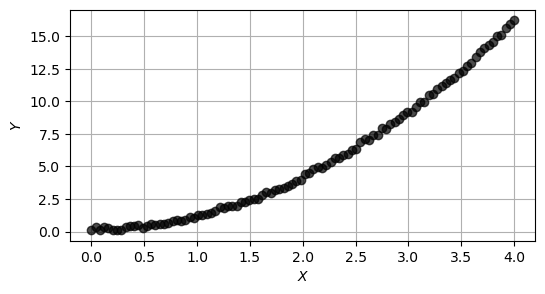

In [3]:
# generate the artificial data

sigma = 0.4
n = 100
X_vec = np.linspace(0, 4, n)  # including 0 here is potentially problematic, do it anyway...
np.random.seed(69)
Y = X_vec**2 + sigma * np.random.rand(n)

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(X_vec, Y, 'ko', alpha=0.7)
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$Y$")
ax.grid()

In this case I am not going to standarise the data nor do a train/test split, because this is really for demonstrating the differences in the behaviours in the linear model.

In this case we know what the data is so it should be clear that we want a model to return $f = X^2$ to us. However I am going to be perverse and assume I don't actually know that, and instead give it a ton of features and ask the model to find me a best fit of those. The features I am going to choose are $(1, X, X^2, X^3 \ldots X^{10})$, where the superscript without the brackets means I am raising it to the power or something. We would like to see whether we get $a_2 \approx 1$, and $a_{j\neq 2} \approx 0$.

To use the linear model formalism I am going to manually create the features via generating an $X$ that looks like
\begin{equation*}
    \begin{pmatrix}
        x_0^0 & x_0^1 & x_0^2 & \cdots & x_0^{10} \\
        x_1^0 & x_1^1 & x_1^2 & \cdots & x_1^{10} \\
        \vdots & \vdots & & & \vdots\\
        x_{99}^0 & x_{99}^1 & x_{99}^2 & \cdots & x_{99}^{10}
    \end{pmatrix},
\end{equation*}
where $x_i^j$ denotes data at position $i$ raised to the power $j$ ($i$-th sample and $j$-th feature). If you remember from your linear algebra, we are trying to get
\begin{equation*}
    \begin{pmatrix}
        x_0^0 & x_0^1 & x_0^2 & \cdots & x_0^{10} \\
        x_1^0 & x_1^1 & x_1^2 & \cdots & x_1^{10} \\
        \vdots & \vdots & & & \vdots\\
        x_{99}^0 & x_{99}^1 & x_{99}^2 & \cdots & x_{99}^{10}
    \end{pmatrix}
    \begin{pmatrix}
        a_0 \\ a_1 \\ \vdots \\ a_{10}
    \end{pmatrix}
    =
    \begin{pmatrix}
        y_0 \\ y_1 \\ \vdots \\ y_{99}
    \end{pmatrix}.
\end{equation*}
Notice the problem here the matrices are not square, and we are in the over-determined regime. The shape above is good for `sklearn` because we want the array in `(n_samples, n_features)`: here we have 100 rows (100 samples), and 11 columns (11 features as degree 10 polynomial + a constant).

Just going to use the default options from the linear models.

/home/jclmak/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.302e+01, tolerance: 2.326e-01
  model = cd_fast.enet_coordinate_descent(
/home/jclmak/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.447e+01, tolerance: 2.326e-01
  model = cd_fast.enet_coordinate_descent(


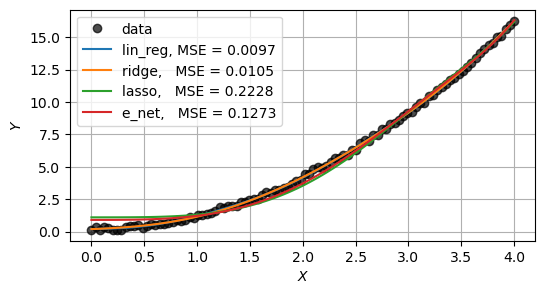

In [4]:
# create input features and do a load of fittings
deg = 10
X = np.zeros((n, deg+1))
for j in range(deg+1):
    X[:, j] = X_vec**j

lin_reg = LinearRegression().fit(X, Y)
ridge = Ridge().fit(X, Y)
lasso = Lasso().fit(X, Y)
e_net = ElasticNet().fit(X, Y)  # I can't get it to converge but it will return an answer

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(X_vec, Y, 'ko', alpha=0.7, label="data")
ax.plot(X_vec, lin_reg.predict(X),
        label=f"lin_reg, MSE = {mean_squared_error(Y, lin_reg.predict(X)):.4f}")
ax.plot(X_vec, ridge.predict(X),
        label=f"ridge,   MSE = {mean_squared_error(Y, ridge.predict(X)):.4f}")
ax.plot(X_vec, lasso.predict(X),
        label=f"lasso,   MSE = {mean_squared_error(Y, lasso.predict(X)):.4f}")
ax.plot(X_vec, e_net.predict(X),
        label=f"e_net,   MSE = {mean_squared_error(Y, e_net.predict(X)):.4f}")
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$Y$")
ax.grid()
ax.legend();

On mine it says `ElasticNet` did not converge, although as you can see the skill is actually ok.

It is of interest also to have a look at the coefficients obtained.

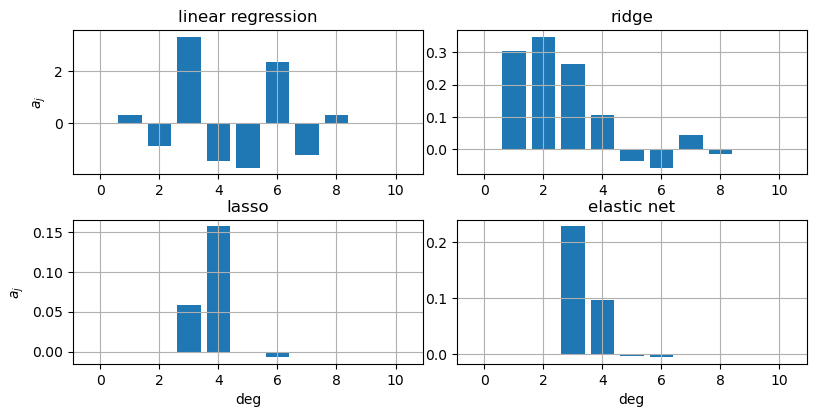

In [5]:
# plot out the coefficients of the models or the loading values?
fig = plt.figure(figsize=(8, 4))

ax = plt.subplot(2, 2, 1)
ax.bar(np.arange(deg+1), lin_reg.coef_)
ax.set_title("linear regression")
ax.set_ylabel(r"$a_j$")
ax.grid()

ax = plt.subplot(2, 2, 2)
ax.bar(np.arange(deg+1), ridge.coef_)
ax.set_title("ridge")
ax.grid()

ax = plt.subplot(2, 2, 3)
ax.bar(np.arange(deg+1), lasso.coef_)
ax.set_title("lasso")
ax.set_xlabel(r"deg")
ax.set_ylabel(r"$a_j$")
ax.grid()

ax = plt.subplot(2, 2, 4)
ax.bar(np.arange(deg+1), e_net.coef_)
ax.set_title("elastic net")
ax.set_xlabel(r"deg")
ax.grid()

plt.tight_layout(pad=0.1);

Several things to notice here:

* Linear regression and ridge both use $L^2$ in the loss, and the result model coefficients are noticeably non-zero across the board (smaller in ridge though). This is not seen in Lasso and elastic net, which include a $L^1$ term in the loss.
* Ridge is really the only one that predicts the loading in the degree 2 term ($a_2$), although there is loading everywhere else.
* Interestingly Lasso predicts a dominant loading at degree 4. This is actually plausible, because for small enough $X$ values (default here being from $0$ to $4$) $X^2$ and $X^4$ can be argued to not be that dissimilar to each other (and analogously argued for other even powers).

Below shows how they perform poorly in extrapolation, demonstrating a signficant issue with over-fitting.

In [6]:
# do a single extrapolation
x0 = 7.0
X_extra = np.zeros((1, deg+1))
for j in range(deg+1):
    X_extra[:, j] = x0**j

# compute some errors
print(f"target value at x0         = {x0**2:.4f}")
print(f"lin_reg extrapolated value = {lin_reg.predict(X_extra)[0]:.6f}")
print(f"ridge   extrapolated value = {ridge.predict(X_extra)[0]:.6f}")
print(f"lasso   extrapolated value = {lasso.predict(X_extra)[0]:.6f}")
print(f"e_net   extrapolated value = {e_net.predict(X_extra)[0]:.6f}")
print(" ")

target value at x0         = 49.0000
lin_reg extrapolated value = 15820.321173
ridge   extrapolated value = -2194.590262
lasso   extrapolated value = 2212.994511
e_net   extrapolated value = 1952.971960
 


> <span style="color:red">Q.</span> See how the above behaviours change if you expand decreasing the training range (e.g. instead of `X_vec = (0, 4)` try `(0, 8)`, or `(4, 8)`, or randomly pick some values to do the model fitting in some specified region etc.)
>
> <span style="color:red">Q.</span> Introduce some variability and do an ensemble of fittings (easiest is via `train_test_split`, although you can do the random picking within a region specified above also). Quantify the robustness of the above properties (e.g. do box-plots/histograms over the ensemble of the loading values, errors etc.)

---
## b) Dimension reduction (cf. data feature identification)

An observation with the above linear model example is that you could in principle get reasonably good model skill without needing a lot of features (e.g. the $L^1$ penalised models). That's a good thing presumably because the resulting model has less complexity that should mitigating over-fitting to some degree, and it also speeds up the training stage in principle (because your problem size is smaller). Ways to identify the most useful "features" for model training/skill is thus of interest: this would be ***dimension reduction*** in that out of the possible space of results allowed by all data, you want to find a useful ***feature space*** that is presumably lower dimension and less complex than the original space.

Asking for the *most* skillful one is probably quite a difficult question to answer. We will instead look for ways to simply find feature spaces that are simpler.

### Principal Component Analysis (PCA)

(Or sometimes Empirical Orthogonal Functions (EOF)s particularly when space dimensions are involved.) 

This we already encountered in OCES 3301, and is essentially finding linear combinations of the features that maximises the variance explained in the data. Again, these are optimisation problems, just with a different choice of loss function.

For example, for the `penguins` data, instead of the feature space being `(bill_length, bill_depth, flipper_length, body_mass)`, it could be that (say) `(bill_length + 2 body_mass, flipper_length + body_mass - bill_depth)` actually explains the data the best. This may not make sense scientifically, but that's not the point: PCA only seeks to maximise variance explained, variance is related to correlations, and correlation does not imply causation.

> <span style="color:red">Q.</span> Have a think why there is no real reason to do a PCA as such for the polynomial fitting problem above.

Although some of this was already done in OCES 3301, the below is included mostly for completeness.

> NOTE: If you know this stuff, then PCA is just a SVD ranked by the magnitude of the singular values. The singular vectors are the features of interest and are orthogonal by construction (hence the O in EOF). When the matrix is square then this is related to diagonalisation of the covariance matrix in terms of its eigenvectors.

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# load the penguin data
option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "penguins.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/penguins.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(path)

loading data remotely


First going to do simple (and arguably unnecessary) case of two variables to two other variables, in which case we are simply dealing with a co-ordinate transformation.

> NOTE: The thing with PCA is that it does depend quite strongly on choice of pre-processing. By default you should do data scaling before you do PCA.

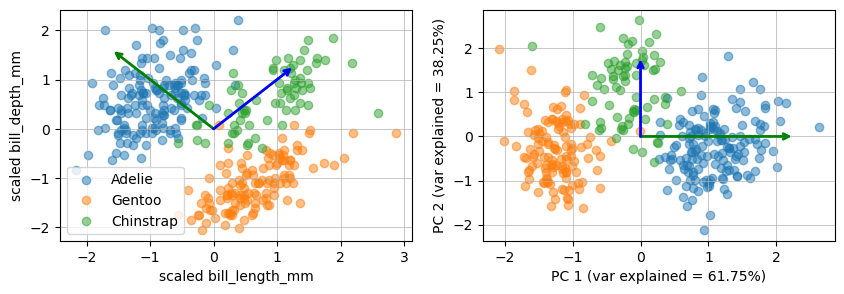

In [8]:
# PCA of two variables to two other variables (i.e. a co-ordinate transformation)
features = ['bill_length_mm', 'bill_depth_mm']
X = df[features].values

# scale and fit the data
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca.fit(X_scaled)

fig = plt.figure(figsize=(10, 3))

# input in scaled space
ax = plt.subplot(1, 2, 1)
for species in df["species"].unique():   # pick out all unique entries under `species`
    ax.scatter(X_scaled[df["species"] == species, 0],
               X_scaled[df["species"] == species, 1],
               label=species,
               alpha=0.5,  # fade this for demonstration later
               )
ax.annotate("",
            pca.mean_ + pca.components_[0] * 2 * np.sqrt(pca.explained_variance_[0]),
            pca.mean_,
            arrowprops=dict(color="green", arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0))
ax.annotate("",
            pca.mean_ + pca.components_[1] * 2 * np.sqrt(pca.explained_variance_[1]),
            pca.mean_,
            arrowprops=dict(color="blue", arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0))
ax.set_xlabel(f"scaled {features[0]}")
ax.set_ylabel(f"scaled {features[1]}")
ax.grid(lw=0.5, zorder=0)
ax.legend()

# inputs in PCA basis
X_pca = pca.transform(X_scaled)

ax = plt.subplot(1, 2, 2)

for species in df["species"].unique():   # pick out all unique entries under `species`
    ax.scatter(X_pca[df["species"] == species, 0],
               X_pca[df["species"] == species, 1],
               label=species,
               alpha=0.5,  # fade this for demonstration later
               )
ax.annotate("",
            [2 * np.sqrt(pca.explained_variance_[0]), 0],
            [0, 0],
            arrowprops=dict(color="green", arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0))
ax.annotate("",
            [0, 2 * np.sqrt(pca.explained_variance_[1])],
            [0, 0],
            arrowprops=dict(color="blue", arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0))
ax.set_xlabel(f"PC 1 (var explained = {pca.explained_variance_ratio_[0]*100:.2f}%)")
ax.set_ylabel(f"PC 2 (var explained = {pca.explained_variance_ratio_[1]*100:.2f}%)")
ax.grid(lw=0.5, zorder=0);

Above looks like a rotation, a flip about the axis defined defined by the blue arrow, and then some mild scaling to me.

A more interesting case is if I dump everything in, which would be a reduction of four dimensions to two dimensions.

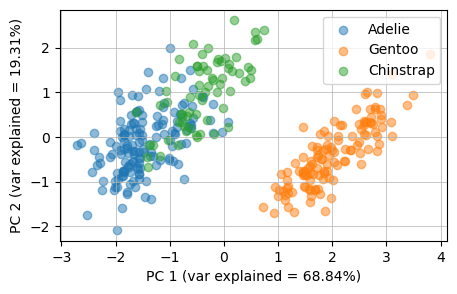

In [9]:
# throw everything into the PCA (in this case ignore species)
features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
X = df[features].values

# scale data, fit PCA (do 2 componens here), transform data
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
for species in df["species"].unique():   # pick out all unique entries under `species`
    ax.scatter(X_pca[df["species"] == species, 0],
               X_pca[df["species"] == species, 1],
               label=species,
               alpha=0.5,  # fade this for demonstration later
               )
ax.set_xlabel(f"PC 1 (var explained = {pca.explained_variance_ratio_[0]*100:.2f}%)")
ax.set_ylabel(f"PC 2 (var explained = {pca.explained_variance_ratio_[1]*100:.2f}%)")
ax.grid(lw=0.5, zorder=0)
ax.legend();

Note the percentages in this case do not sum to 100%, because we have discarded two dimensions. We can query the percentages and also the feature combinations as follows.

In [10]:
# print to screen the percentages and PC constituents

for i in range(len(pca.explained_variance_ratio_)):
    print(f"PC {i+1} explains {pca.explained_variance_ratio_[i]*100:.2f}% of variance")
print(" ")
for i in range(len(pca.explained_variance_ratio_)):
    print(f"""PC {i+1} = {pca.components_[i, 0]:.4f} * {features[0]} +
       {pca.components_[i, 1]:.4f} * {features[1]} +
       {pca.components_[i, 2]:.4f} * {features[2]} +
       {pca.components_[i, 3]:.4f} * {features[3]}""")
print(" ")

PC 1 explains 68.84% of variance
PC 2 explains 19.31% of variance
 
PC 1 = 0.4553 * bill_length_mm +
       -0.4003 * bill_depth_mm +
       0.5760 * flipper_length_mm +
       0.5484 * body_mass_g
PC 2 = 0.5970 * bill_length_mm +
       0.7978 * bill_depth_mm +
       0.0023 * flipper_length_mm +
       0.0844 * body_mass_g
 


### Locally Linear Embedding and $t$-SNE

The original paper to ***Locally Linear Embedding*** is [here](https://www.science.org/doi/10.1126/science.290.5500.2323). This you can think of as PCAs done locally, and these local regions are patched together to form a best fit global reduction. Below just demonstrates how these are used with the penguin data, although it may make more sense after next lecture with a better example where it will significantly affect the results from clustering.

> NOTE: This I think is a bit like in differential geometry where you find a whole load of local co-ordinate charts, and then patch it up to find a global atlas.

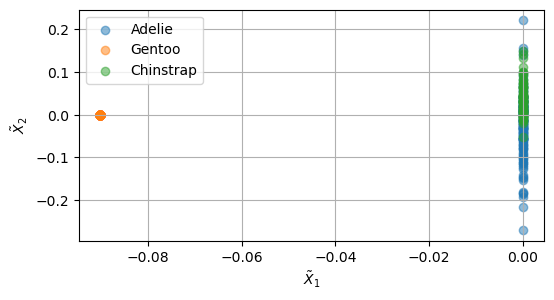

In [11]:
from sklearn.manifold import LocallyLinearEmbedding

features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
X = df[features].values

lle = LocallyLinearEmbedding()  # default of 2 components (so 2 dimensions)
X = StandardScaler().fit_transform(X)  # comment to switch of scaling if wanted
X_lle = lle.fit_transform(X)

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
for species in df["species"].unique():   # pick out all unique entries under `species`
    ax.scatter(X_lle[df["species"] == species, 0],
               X_lle[df["species"] == species, 1],
               label=species,
               alpha=0.5,  # fade this for demonstration later
               )
ax.set_xlabel(r"$\tilde{X}_1$")
ax.set_ylabel(r"$\tilde{X}_2$")
ax.grid()
ax.legend();

This seems to suggest there is a projection that can strongly separate out the Gentoo penguins from others, which may help in classification tasks.

> <span style="color:red">Q.</span> The default option above is `standard`, but there are other options that can be specified (e.g. `ltsa`, `hessian`, `modified`). See [here](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html#sklearn.manifold.LocallyLinearEmbedding) for what those mean and try a few of those out. Might also be good to revisit after the next session.

***$t$-distributed Stochastic Neighbor Embedding*** ($t$-SNE) tries to do something similar but instead assigns how close data is in the original space by Gaussian probabilities, and the closeness in the transformed space by Student $t$-distributions (cf. `05_hypothesis_testing` in OCES 3301). Together this aids in looking for a projection that is sensitive to local data structures. While the former method is better for continuously distributed samples, the method here might be better for local samples.

> NOTE: $t$-SNE can be slow.
>
> The default has `TSNE(init="pca")`, which helps with stability. `init="random"` is the other option.

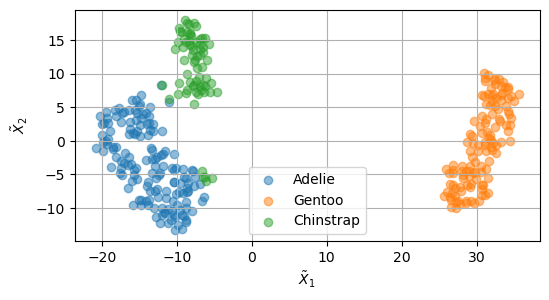

In [12]:
from sklearn.manifold import TSNE

features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
X = df[features].values

tsne = TSNE()  # default of 2 components (so 2 dimensions)
X = StandardScaler().fit_transform(X)  # comment to switch of scaling if wanted
X_tsne = tsne.fit_transform(X)

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
for species in df["species"].unique():   # pick out all unique entries under `species`
    ax.scatter(X_tsne[df["species"] == species, 0],
               X_tsne[df["species"] == species, 1],
               label=species,
               alpha=0.5,  # fade this for demonstration later
               )
ax.set_xlabel(r"$\tilde{X}_1$")
ax.set_ylabel(r"$\tilde{X}_2$")
ax.grid()
ax.legend();

So note here that we get fairly well separated clusters of points (with a little bit of mixing between Adelie and Chinstrap), which will presumably aid in clustering and/or classification tasks.

> <span style="color:red">Q.</span> Switch off data standardisation and see what happens. Is this expected?
>
> <span style="color:red">Q.</span> Change over to `init="random"` and see how the clustering changes. You may want to run multiple instances to check for robustness and/or wellness of separation.

### Demonstration: Eigencat

A fun application of PCA would be the [eigenpets](https://bioramble.wordpress.com/2015/09/01/pca-part-5-eigenpets/) example (cf. [eigenfaces](https://en.wikipedia.org/wiki/Eigenface)). Given a collection of cat images, what is the "pattern" that explains most of the data in terms of maximising the variance? This has uses in things like image/facial recognition: you might imagine certain species of cats have a particular signature in some modes. More generally, this might be useful in ***classification*** tasks where you are trying to identify species and the like. Having these features may also be helpful for reconstruction of broken images.

The idea is quite simple: instead of a set of images being `(n_samples, width, height)`, we simply reshape/flatten it into `(n_samples, pixels)`; this is what was done for computing EOFs in OCES 3301. Then you dump it into the PCA routine as usual. We first have a load and plot out some of the dataset.

loading data remotely
data array shape is (80, 4096)
 


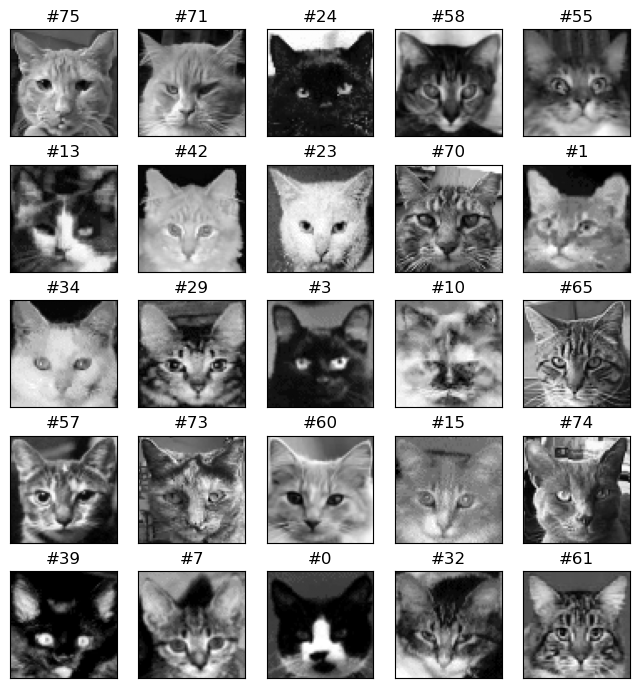

In [13]:
# don't read the headers

option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "cat.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/cat.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(path, header=None).T # make "features" the axis=-1
X = df.values
print(f"data array shape is {X.shape}")
print(" ")

# generate a list of 25 indices (generate full list, shuffle, select first 25, so no repeats)
ind = np.arange(80)
np.random.shuffle(ind)  # syntax for shuffle: not used like a function with input output...

# sample show (on-the-fly reshape data)
fig = plt.figure(figsize=(8, 8.5))
for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    ax.imshow(np.reshape(X[ind[i], :], (64, 64)).T, cmap="gray")
    ax.set_title(f"#{ind[i]}")
    ax.set_xticks([]); ax.set_yticks([]);

Here the raw data has already been flattened and is in the right shape (otherwise just transpose it with `.T`). We will PCA it accordingly, but I won't standardise it in this case (though probably should to remove the mean).

> <span style="color:red">Q.</span> Have a think why I made that choice, and possibly investigate later what consequences you may have if you do standardise in the usual way (uncomment two of the lines below), or with other choices of standardisation.

In [14]:
# if standardising then images are less sharp (Q: why?)
# scale = StandardScaler()
# X = scale.fit_transform(X)
pca = PCA(n_components=40)
X_pca = pca.fit_transform(X)

# should be (n_EOF, pixels)
print(f"PCA components with shape {pca.components_.shape}")
print(" ")

PCA components with shape (40, 4096)
 


The transformed data should be in the shape `(n_EOF, pixels)`. We can reshape and plot them out accordingly.

Note that I am calling the patterns the EOFs, while the loadings I am going call the PCs. In this case the mathematical expresion might be less ambiguous:
\begin{equation*}
    \mathrm{Image}(\mathrm{pixels}) = \sum_i \mbox{PC}_i \times \mbox{EOF}_i(\mathrm{pixels}),
\end{equation*}
and each of the cat image differs in the $\mbox{PC}_i$.

> NOTE: If you are mathematically inclined, EOFs are just the basis of singular vectors and the PCs are my co-ordinates or coefficients in this basis.

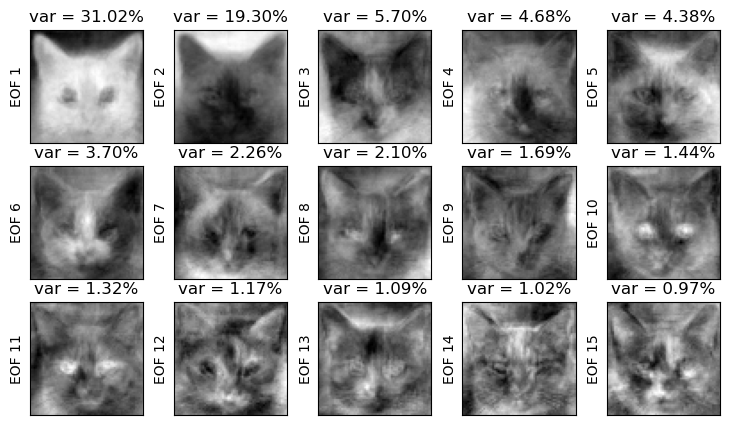

In [15]:
# eigencats
fig = plt.figure(figsize=(9, 5))
for i in range(15):
    ax = plt.subplot(3, 5, i+1)
    ax.imshow(np.reshape(pca.components_[i, :], (64, 64)).T, cmap="gray")
    ax.set_title(f"var = {pca.explained_variance_ratio_[i] * 100:.2f}%")
    ax.set_ylabel(f"EOF {i+1}")
    ax.set_xticks([]); ax.set_yticks([]);

Some observations:

* Here you might think EOF1 probably measures colour: if the associated PC1 is positive then we are dealing with lighter coloured cats probably, and vice-versa for negative PC1s.
* EOF2 and 3 might be about facial patterns.
* EOF4 and 5 might be about "chubby-ness" of face?
* Extra details on the later patterns.

These are all speculations of course, because again PCA is statistical and only finds the correlations, whereas it is me who attributes the causality.

Below are some selected examples of cats with increasing numbers of EOFs added, i.e. I am doing
\begin{equation*}
    \mathrm{Reconstructed\ Image}(\mathrm{pixels}) \approx \sum_i^m \mbox{PC}_i \times \mbox{EOF}_i(\mathrm{pixels})
\end{equation*}
with increasing $m$. I am also going to plot out the corresponding loading values $\mbox{PC}_i$ as a graph for the selected samples.

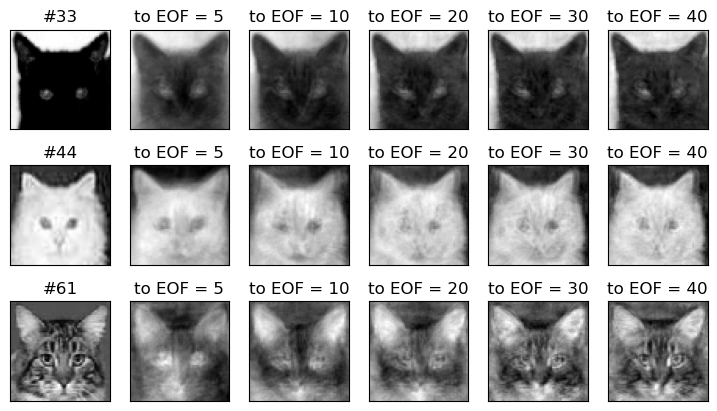

In [16]:
# sample decomposition (X_pca above is the PC)

cat_num = [33, 44, 61]
pca_ind = [5, 10, 20, 30, 40]

# do some plots to show decomposition
fig = plt.figure(figsize=(9, 5))

count = 0

for j in range(3):
    cat_ind = cat_num[j]
    for i in range(6):
        ax = plt.subplot(3, 6, (j*6)+i+1)
        # plot original image
        if i % 6 == 0:
            ax.imshow(np.reshape(X[cat_ind, :], (64, 64)).T, cmap="gray")
            ax.set_title(f"#{cat_num[j]}")
        # plot the reconstruction with increasing number of PCs
        else:
            # sum to get (scaled) reconstruction via sum_i (PC_i * EOF_i)
            ind = pca_ind[i-1]
            dum = np.sum(X_pca[cat_ind, :ind] * pca.components_[:ind, :].T, axis=-1)
            ax.imshow(np.reshape(dum, (64, 64)).T, cmap="gray")
            ax.set_title(f"to EOF = {pca_ind[i-1]}")
            count += 1

        ax.set_xticks([]); ax.set_yticks([]);

In [17]:
# NOTE: the shape !!
print('Shape of X: ', X.shape)
print("Shape of X_pca: ", X_pca.shape)
print("Shape of EOFs: ", pca.components_.shape)
# reconstruction is similar to this (add mean for reverse shifting / centering)
X_recon = np.dot(X_pca, pca.components_) + pca.mean_[np.newaxis, :]
print("Matrix multiplication, Shape(X_pca * EOFs) = ", (X_recon).shape)

# wont be able to exactly reconstruct the original images, try plotting to see
# plt.imshow(np.reshape(X[0, :], (64, 64)).T, cmap="gray")
# plt.imshow(np.reshape(X_recon[0, :], (64, 64)).T, cmap="gray")

Shape of X:  (80, 4096)
Shape of X_pca:  (80, 40)
Shape of EOFs:  (40, 4096)
Matrix multiplication, Shape(X_pca * EOFs) =  (80, 4096)


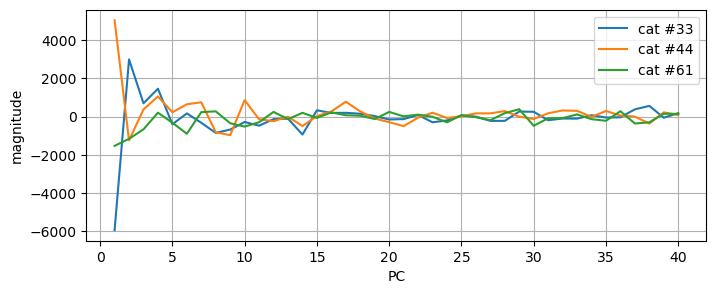

In [18]:
# plot out the PC decomposition
fig = plt.figure(figsize=(8, 3))
ax = plt.axes()
for cat in cat_num:
    ax.plot(np.arange(1, X_pca.shape[-1]+1), X_pca[cat, :], label=f"cat #{cat}")
ax.set_xlabel("PC"); ax.set_ylabel("magnitude")
ax.grid()
ax.legend();

Perhaps as expected we see that the black and white cat differs primarily in PC1. The tabby cat has a different signature on the other hand. This may aid in the classification of images via a machine learning algorithm in the following ways:

* The different signatures might be distinguishing feature that allows separation of labels (see session 05 when we talk about classification tasks).
* Instead of throwing the above images (which is $64^2 = 4096$ features, i.e. high dimension feature space), we are instead doing learning in a much lower dimension space (in this case 40), which may be good in mitigation of over-fitting.

### A fun demonstration and also a warning

I am going to go nuts and load an even larger dataset and do the same thing. Here I am going to do a PCA with 2000 components (again not standardising). This takes a bit of time (no more than 10 seconds on my laptop, around 20 seconds in Colab).

In [19]:
# 2000 images here; data ordering with the same convention
option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "cat_bw_enlarged.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/cat_bw_enlarged.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(path, header=None).T # make "features" the axis=-1

loading data remotely


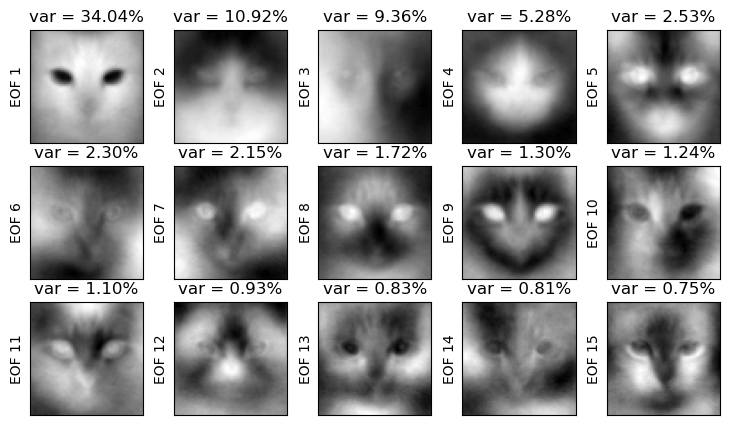

In [20]:
# expanded eigencats
X = df.values
pca = PCA(n_components=2000)
X_pca = pca.fit_transform(X)

fig = plt.figure(figsize=(9, 5))
for i in range(15):
    ax = plt.subplot(3, 5, i+1)
    ax.imshow(np.reshape(pca.components_[i, :], (64, 64)).T, cmap="gray")
    ax.set_title(f"var = {pca.explained_variance_ratio_[i] * 100:.2f}%")
    ax.set_ylabel(f"EOF {i+1}")
    ax.set_xticks([]); ax.set_yticks([]);

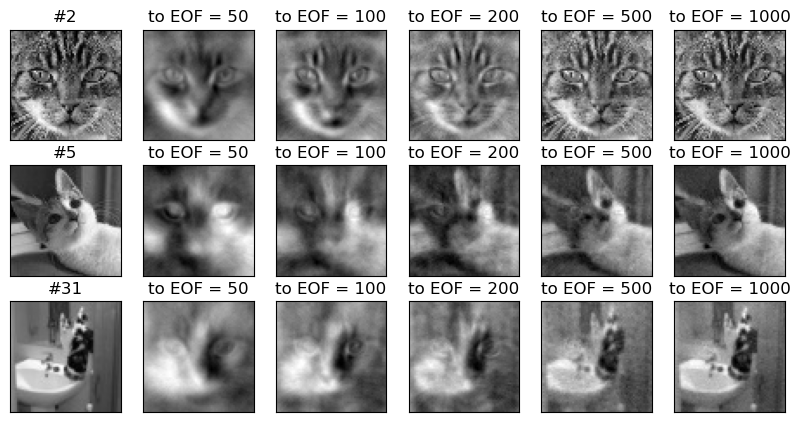

In [21]:
# sample decomposition (X_pca above is the PC)

cat_num = [2, 5, 31]
pca_ind = [50, 100, 200, 500, 1000]

# do some plots to show decomposition
fig = plt.figure(figsize=(10, 5))

for j in range(3):
    cat_ind = cat_num[j]
    for i in range(6):
        ax = plt.subplot(3, 6, (j*6)+i+1)
        # plot original image
        if i % 6 == 0:
            ax.imshow(np.reshape(X[cat_ind, :], (64, 64)).T, cmap="gray")
            ax.set_title(f"#{cat_num[j]}")
        # plot the reconstruction with increasing number of PCs
        else:
            # sum to get (scaled) reconstruction via sum_i (PC_i * EOF_i)
            ind = pca_ind[i-1]
            dum = np.sum(X_pca[cat_ind, :ind] * pca.components_[:ind, :].T, axis=-1)
            ax.imshow(np.reshape(dum, (64, 64)).T, cmap="gray")
            ax.set_title(f"to EOF = {pca_ind[i-1]}")

        ax.set_xticks([]); ax.set_yticks([]);

So notice that this larger dataset is not as clean in that we have cat images that are:

* Missing features (the first one isn't showing the ears).
* Not centred (includes whole fact but rotated somewhat).
* Not focused (showing whole body as well as other presumably irrelevant features).

By enlarging the dataset with extra details I am massively increasing the dimension and extent of my feature space, which may or may not be a good thing. With this I can fit whatever I like to the trained set, as demonstrated below.

In [22]:
import requests
from PIL import Image
from io import BytesIO

targets_path = {
    "miffy_gormless" : "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/miffy_gormless.jpg",
    "blauhaj" : "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/blauhaj.jpg",
    "clippy" : "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/clippy.jpg",
}

targets = {}

for file_name, file_url in targets_path.items():
    response = requests.get(file_url)
    targets[file_name] = Image.open(BytesIO(response.content))

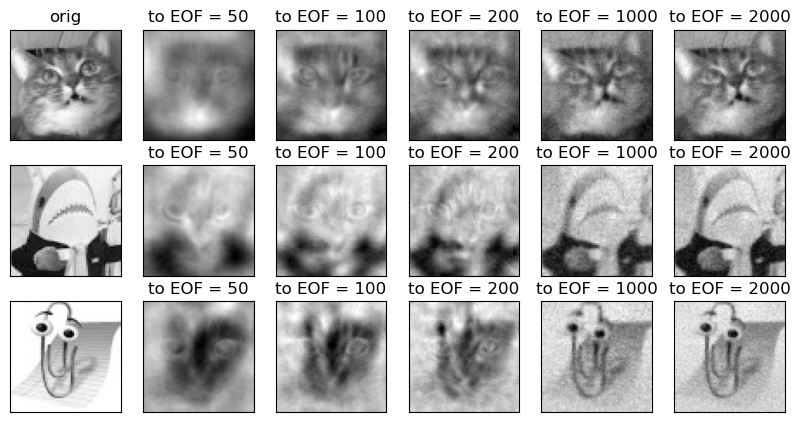

In [23]:
# fit some doofuses
pca_ind = [50, 100, 200, 1000, 2000]

# do some plots to show decomposition
fig = plt.figure(figsize=(10, 5))

j = 0
for key in targets:
    X = np.array(targets[key]).T.flatten()
    X_pca = pca.transform(X.reshape(1, -1))
    for i in range(6):
        ax = plt.subplot(3, 6, (j*6)+i+1)
        # plot original image
        if i % 6 == 0:
            ax.imshow(np.reshape(X, (64, 64)).T, cmap="gray")
            if j == 0:
                ax.set_title("orig")
        # plot the reconstruction with increasing number of PCs
        else:
            # sum to get (scaled) reconstruction via sum_i (PC_i * EOF_i)
            ind = pca_ind[i-1]
            dum = np.sum(X_pca[0, :ind] * pca.components_[:ind, :].T, axis=-1)
            ax.imshow(np.reshape(dum, (64, 64)).T, cmap="gray")
            ax.set_title(f"to EOF = {pca_ind[i-1]}")

        ax.set_xticks([]); ax.set_yticks([]);
    j += 1

With the expanded set I can fit:

* A cat that wasn't in the sample.
* An animal that's not a cat.
* Not even an animal.

The first is good but the latter are not. You can imagine I train a classifier, then it might identify the bottom one as a "siamese cat".

A take home message here may be that more data is not always good: it does expose the models to the wider pdf, but it also allows for more possibility of hallucinations with the extra complexity. Just like "practice makes perfect" is really "PERFECT practice makes perfect", we should really have "more GOOD data is good".

> NOTE: There are of course data choices that can be used to mitigate these hallucinations (a simple one would be to add `not cat` labels). There are also model design choices that can be taken as well, but those will be beyond the scope of this course.

> <span style="color:red">Q.</span> Exercise in data processing: Find your favourite image and try and see if you can expand it with the enlarged eigenpets collection. (You will need to resize and grayscale it.)
>
> <span style="color:red">Q.</span> Consider doing locally linear embedding or $t$-SNE instead of PCA in the above dataset(s). Probably don't do it on the extended cat set particularly with $t$-SNE, because that will probably kill your computer.

---
## c) Clustering

Given unlabelled data it may be of interest to label them according to how "close" the data is to each other. ***Clustering*** is a means to do this". One reason to do clustering is that you may want to have different regression models or train regression models differently depending on the data. Piggy-backing on some previous material:

1. From the `penguins` example you may remember that Gentoo has somewhat different properties compared to the other two. Models trained on everything is not expected to work that well (and it doesn't). In that case it is obvious to split by `species` (because that already comes with the data), but you could imagine you got unlabelled data instead. Then you'd want to cluster first and then possibly train the model based on the labelled data.
2. You may want to reduce dimension to separate out data, then cluster, then train models accordingly. The labels also provide extra features that could be fed to the model.

> NOTE: The above points are things you should probably consider doing certainly if you are going to use Argo data for assignment 1.

Clustering algorithms work by having some measure of "closeness", whatever you want that to mean. Going to demonstrate roughly how clustering algorithms might work and some subtleties related to the measure of "closeness".

> NOTE: This is again a problem in the choice of "metric".

### $K$-means clustering

A simple case for clustering that we can demonstrate reasonably easily is ***$K$-means clustering***. I am going to demonstrate how this works in 2d manually first, and the generalisation to arbitrary dimensions and use in `sklearn` should be fairly obvious.

### 0. Create some data first

Below I am going to artificially create three blobs of data (and kicked around by some noise). By eye it should be suggestive that there would be three clusters.

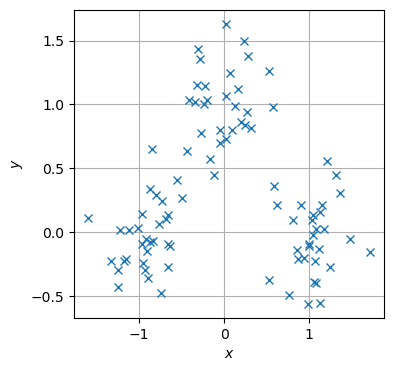

In [24]:
# create cluster centers (in a triangle in this case), then add noise to them
X = np.concat((np.ones((30, 2)) * [ 0.0, 1.0],
               np.ones((30, 2)) * [ 1.0, 0.0],
               np.ones((30, 2)) * [-1.0, 0.0]))
X += 0.25 * np.random.randn(X.shape[0], 2)  # made this small-ish so clusters show up

fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.plot(X[:, 0], X[:, 1], 'x')
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$");
ax.grid();

### 1. Specify number of clusters $K$ and location of their initial centroid

A user defined parameter (and thus a model hyper-parameter) is the number of clusters $K$ (hence $K$-means). Step 0 of plotting out the data suggests to me maybe I should choose $K = 3$, so I do that and in this case take an educated guess where the centres of the clusters (the **centroid**) are; we will consider the randomly initialised case later.

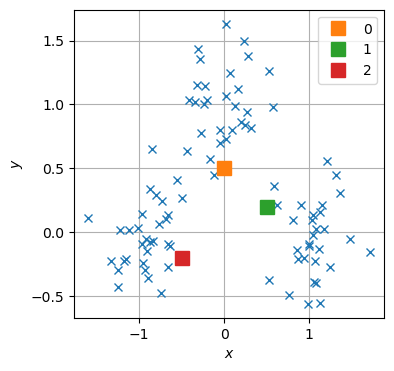

In [25]:
# initialise centroid guesses and plot where these are
centroid = np.array([[0.0, 0.5], [0.5, 0.2], [-0.5, -0.2]]) # centroid[number, coord]

fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.plot(X[:, 0], X[:, 1], 'x')
for i in range(centroid.shape[0]):
    ax.plot(centroid[i, 0], centroid[i, 1], 's', markersize=10, label=f"{i}")
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$");
ax.grid()
ax.legend();

### 2. Label the clusters according to how close they are to the centroids

This depends on the choice of distance, and the usual (but not the only) choice is to take the $L^2$ distance (sometimes called ***Euclidean distance***). Below I do just that although I ignore the square root procedure: if you had units you would need a square root to get a distance, but the magnitude ordering is exactly the same.

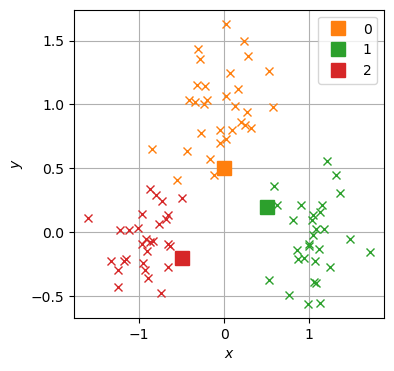

In [26]:
# iterate by computing distances and assigning labels to points closest to centroids

# L2 or root-mean-square distance (the root is not actually important here)
dist = np.sum((X - centroid[0, :]) ** 2, axis=-1)  # sum along the co-ord dimension
label = np.zeros(X.shape[0])  # set everything to belong to zero for now

for i in range(1, centroid.shape[0]):
    # compute new distance, and update baseline references as appropriate
    dist_dum = np.sum((X - centroid[i, :]) ** 2, axis=-1)
    label = np.where(dist_dum < dist, i, label)
    dist = np.where(dist_dum < dist, dist_dum, dist)

fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
for i in range(centroid.shape[0]):
    ax.plot(X[label==i, 0], X[label==i, 1], f"C{i+1}x")
    ax.plot(centroid[i, 0], centroid[i, 1], f"C{i+1}s", markersize=10, label=f"{i}")
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$");
ax.grid()
ax.legend();

### 3. Update the centroid locations, and iterate

Give the identified clusters, find the "centres" of those. I found it below by doing an optimistion problem (find the $L^2$ minimiser), although I am thinking you could probably just take an average (although something doesn't feel right with the procedre to me...)

Then you iterate until some tolerance has been reached (e.g. the centroids don't move that much after a certain point, the classification hasn't changed after enough iterations etc.)

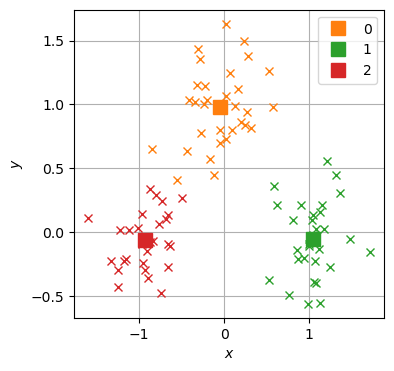

In [27]:
# compute new centroid location from classification solving an optimisation problem
from scipy.optimize import minimize

# define the cost function
def func(centroid, X):
    return np.sum((X - centroid)**2)  # want the L2 minimiser

# cycle through the data and update the centroids
for i in range(centroid.shape[0]):
    res = minimize(func, centroid[i, :], args=X[label==i, :])
    centroid[i, :] = res.x

# plot new locations
fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
for i in range(centroid.shape[0]):
    ax.plot(X[label==i, 0], X[label==i, 1], f"C{i+1}x")
    ax.plot(centroid[i, 0], centroid[i, 1], f"C{i+1}s", markersize=10, label=f"{i}")
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$");
ax.grid()
ax.legend();

### Doing this through `sklearn`

A good exercise is to try writing your own $K$-means (mine wraps all of the above in about 30 lines of code). Failing that, we could use `sklearn`. Below code cells demonstrate the relevant syntax with the artificial data above and considers varying the initial guess via specifying `random_state`.

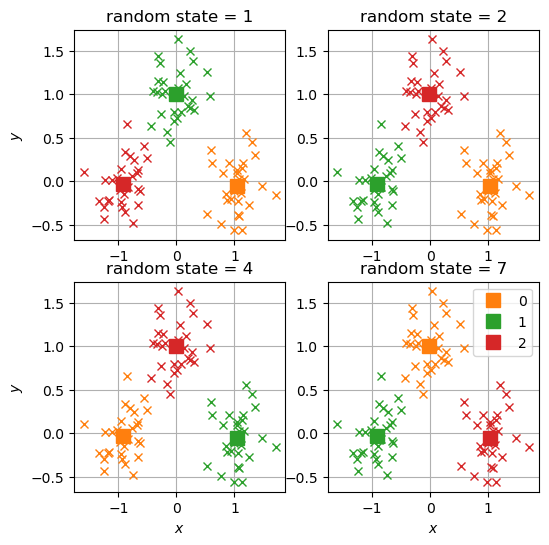

In [28]:
# load packages
from sklearn.cluster import KMeans

random_states = [1, 2, 4, 7]

fig = plt.figure(figsize=(6, 6))

for j in range(len(random_states)):
    # initialise model, fit and then return labels
    model = KMeans(n_clusters=3, random_state=random_states[j])
    model.fit(X)
    label = model.predict(X)  # could have used "model.fit_predict"

    ax = plt.subplot(2, 2, j+1)
    for i in range(model.n_clusters):
        ax.plot(X[label==i, 0], X[label==i, 1], f"C{i+1}x")
        ax.plot(model.cluster_centers_[i, 0], model.cluster_centers_[i, 1], f"C{i+1}s",
                markersize=10, label=f"{i}")
    if j > 1:
        ax.set_xlabel(r"$x$")
    if j % 2 == 0:
        ax.set_ylabel(r"$y$");

    ax.set_title(f"random state = {random_states[j]}")
    ax.grid()

ax.legend();

The thing to note here is that the clusters themselves are fairly robust although the labels differ. That's a mild annoyance if wanting to use this to compare with already labelled data, but a relabelling will fix that if need be.

The algorithm generalises to high dimensions if you think of a piece of data as some point in some high dimensional space with co-ordinates given by each of the numbers in the features dimension, and taking the higher dimension analogue of the $L^2$ distance.

> <span style="color:red">Q.</span> Have a think what would happen to the classification if two data points happen to have identical distances.

### Revisiting manifold methods (e.g. lle and $t$-SNE above)

As noted one needs to then be a bit careful about the choice of distance. In the below example I have two half moons in 2d and an swiss-roll shaped data in 3d, using a tool already in `sklearn` (and is nicer than the examples I manually tried to generate). I am going to apply $K$-means to it as usual.

> NOTE: The `make_s_curve` one is a good choice for 3d testing too.

<img src="https://i.imgur.com/rOgacgN.png" width="450" alt='moon and swiss roll'>

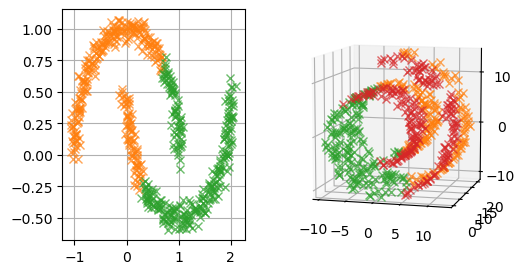

In [29]:
from sklearn.datasets import make_moons, make_swiss_roll

n_samples = 600
X_moon, _ = make_moons(n_samples, noise=0.05)     # don't need labels
X_swiss, swiss_color = make_swiss_roll(n_samples, noise=0.01)  # don't need swiss_color just yet

fig = plt.figure(figsize=(8, 3))

# moon data should have 2 clusters
ax = plt.subplot2grid((1, 3), (0, 0))
label = KMeans(n_clusters=2).fit_predict(X_moon)
for i in range(2):
    ax.plot(X_moon[label==i, 0], X_moon[label==i, 1], f"C{i+1}x", alpha=0.7)
ax.grid()

# S data is one continuous thing, 3 clusters for now
ax = plt.subplot2grid((1, 3), (0, 1), colspan=2, projection="3d")
label = KMeans(n_clusters=3, random_state=0).fit_predict(X_swiss)
for i in range(3):
    ax.plot(X_swiss[label==i, 0],
            X_swiss[label==i, 1],
            X_swiss[label==i, 2], f"C{i+1}x", alpha=0.7)
ax.view_init(azim=-75, elev=9)
ax.set_box_aspect((1, 1, 1))
ax.set_anchor("W");

Both of these demonstrate cases where in this case the ambient measure of distance (in this case $L^2$ in $\mathbb{R}^2$ and $\mathbb{R}^3$) is not the relevant distance: the data has a distribution that lives on some surface (which I are going calling the ***manifold***), and it is the ***intrinsic*** measure of distance on the manifold that should be the relevant one, rather than the ***extrinsic*** one inherited from the data manifold being embedded in this case in and $\mathbb{R}^2$ and $\mathbb{R}^3$. One could argue for example that:

* The two moons are really 1d curves living in $\mathbb{R}^2$ up to noise.
* The Swiss roll is really a 2d surface living in $\mathbb{R}^3$ up to noise.

This is where the previous dimension reduction techniques may be useful: you take the data and try and find a projection onto a lower dimension space to pull out the key features (cf. a co-ordinate "transformation"), then in the transformed space your usual "distance" may actually make sense, then you do clustering on that.

Below demonstrates that with the moon data first, where we expect two clusters.

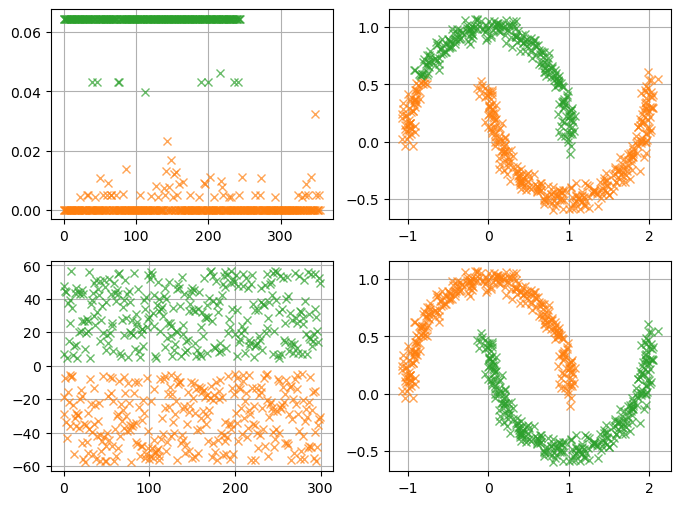

In [30]:
from sklearn.manifold import LocallyLinearEmbedding, TSNE

# find 1d projections of 2d data
lle = LocallyLinearEmbedding(n_components=1, random_state=777)
tsne = TSNE(n_components=1, random_state=777)
X_moon_lle = lle.fit_transform(X_moon)
X_moon_tsne = tsne.fit_transform(X_moon)

fig = plt.figure(figsize=(8, 6))

# predicting after LLE transformation
label = KMeans(n_clusters=2).fit_predict(X_moon_lle)
ax = plt.subplot(2, 2, 1)
for i in range(2):
    ax.plot(X_moon_lle[label==i, 0], f"C{i+1}x", alpha=0.7)
ax.grid()

ax = plt.subplot(2, 2, 2)
for i in range(2):
    ax.plot(X_moon[label==i, 0], X_moon[label==i, 1], f"C{i+1}x", alpha=0.7)
ax.grid()

# predicting after TSNE transformation
label = KMeans(n_clusters=2).fit_predict(X_moon_tsne)
ax = plt.subplot(2, 2, 3)
for i in range(2):
    ax.plot(X_moon_tsne[label==i, 0], f"C{i+1}x", alpha=0.7)
ax.grid()

ax = plt.subplot(2, 2, 4)
for i in range(2):
    ax.plot(X_moon[label==i, 0], X_moon[label==i, 1], f"C{i+1}x", alpha=0.7)
ax.grid();

So this one does actually work reasonably well as long as I do a 1d projection, rather than a 2d transformation (which I started off with for some stupid reason in hindsight). The $t$-SNE projection is more robust generally than the LLE one, at least from my empirical testing.

> <span style="color:red">Q.</span> I find that depending on the initialisation of the data (because the `random_state` is already fixed) the LLE approach is a bit brittle, while the $t$-SNE case is more robust. Consider doing an ensemble of these and test for the robustness.
>
> <span style="color:red">Q.</span> Try a 2d co-ordinate transformation instead. You will need to modify the plotting code somewhat.

Below shows an analogous approach on swiss roll data.

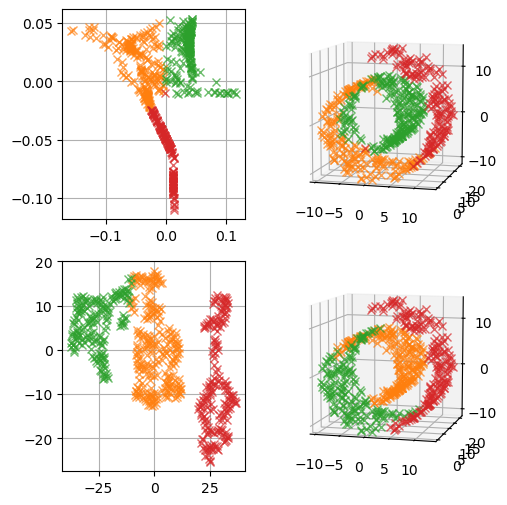

In [31]:
# find 2d projections (because original data is in 3d)

lle = LocallyLinearEmbedding(n_components=2, random_state=777)
tsne = TSNE(n_components=2, random_state=777)
X_swiss_lle = lle.fit_transform(X_swiss)
X_swiss_tsne = tsne.fit_transform(X_swiss)

fig = plt.figure(figsize=(8, 6))

# predicting after LLE transformation
label = KMeans(n_clusters=3).fit_predict(X_swiss_lle)
ax = plt.subplot2grid((2, 3), (0, 0))
for i in range(3):
    ax.plot(X_swiss_lle[label==i, 0],
            X_swiss_lle[label==i, 1], f"C{i+1}x", alpha=0.7)
ax.grid()

ax = plt.subplot2grid((2, 3), (0, 1), colspan=2, projection="3d")
for i in range(3):
    ax.plot(X_swiss[label==i, 0],
            X_swiss[label==i, 1],
            X_swiss[label==i, 2], f"C{i+1}x", alpha=0.7)
ax.view_init(azim=-75, elev=9)
ax.set_box_aspect((1, 1, 1))
ax.set_anchor("W")

# predicting after LLE transformation
label = KMeans(n_clusters=3).fit_predict(X_swiss_tsne)
ax = plt.subplot2grid((2, 3), (1, 0))
for i in range(3):
    ax.plot(X_swiss_tsne[label==i, 0],
            X_swiss_tsne[label==i, 1], f"C{i+1}x", alpha=0.7)
ax.grid()

ax = plt.subplot2grid((2, 3), (1, 1), colspan=2, projection="3d")
for i in range(3):
    ax.plot(X_swiss[label==i, 0],
            X_swiss[label==i, 1],
            X_swiss[label==i, 2], f"C{i+1}x", alpha=0.7)
ax.view_init(azim=-75, elev=9)
ax.set_box_aspect((1, 1, 1))
ax.set_anchor("W");

In the swiss roll case it looks like the approaches are able to find segments of the data appropriately, but this is again slightly more brittle depending on initialisations.

> <span style="color:red">Q.</span> Again, consider doing an ensemble of these and test for the robustness.

### DBSCAN

Instead of $K$-means there is an approach called `DBSCAN`, which asserts that clusters occur as high density of data points separated by gaps that are lower density. This is more a local approach and can also be flexible with the choice of metric (hence it's grouping here), although it does have potential drawbacks in that there are more model hyperparameters (`min_samples` and `eps` to give a measure what is meant by "dense"); the number of clusters that falls out is a result of those two choices (and thus we have less control on what drops out). Below shows the two demonstrations with the moons and swiss roll data in the original embedding space.

> NOTE: The black dots are **noise points** and has a label of `-1`. These are points close enough to multiple identified clusters that DBSCAN is unable to classify them.

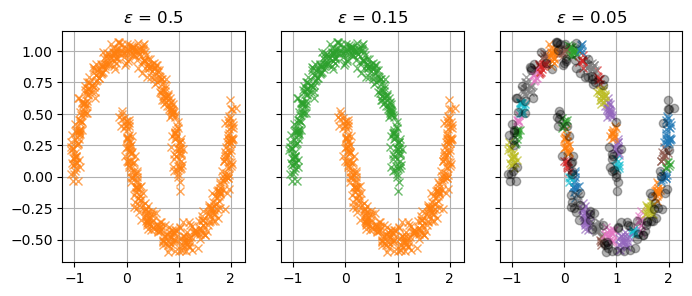

In [32]:
from sklearn.cluster import DBSCAN

# moon data
eps_vec = [0.5, 0.15, 0.05]  # keep default of min_samples = 5

fig = plt.figure(figsize=(8, 3))

# moon data should have 2 clusters
for j in range(len(eps_vec)):
    ax = plt.subplot(1, 3, j+1)
    label = DBSCAN(eps=eps_vec[j]).fit(X_moon).labels_
    # identify number of labels
    n_clusters = len(set(label)) - (1 if -1 in label else 0)
    for i in range(n_clusters):
        ax.plot(X_moon[label==i, 0], X_moon[label==i, 1], f"C{i+1}x", alpha=0.7)
    ax.plot(X_moon[label==-1, 0], X_moon[label==-1, 1], f"ko", alpha=0.3)  # noise points
    ax.grid()
    ax.set_title(f"$\epsilon$ = {eps_vec[j]}")
    if j > 0:
        ax.set_yticklabels([])

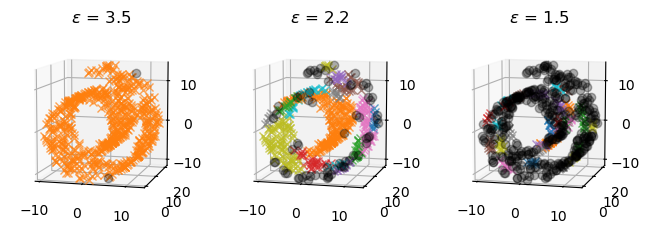

In [33]:
# swiss roll data
eps_vec = [3.5, 2.2, 1.5]  # keep default of min_samples = 5

fig = plt.figure(figsize=(8, 3))

# swiss roll data is one continuous cluster
for j in range(len(eps_vec)):
    ax = plt.subplot(1, 3, j+1, projection="3d")
    label = DBSCAN(eps=eps_vec[j]).fit(X_swiss).labels_
    # identify number of labels
    n_clusters = len(set(label)) - (1 if -1 in label else 0)

    for i in range(n_clusters):
        ax.plot(X_swiss[label==i, 0],
                X_swiss[label==i, 1],
                X_swiss[label==i, 2], f"C{i+1}x", alpha=0.7)
    ax.plot(X_swiss[label==-1, 0],
            X_swiss[label==-1, 1],
            X_swiss[label==-1, 2], f"ko", alpha=0.3)  # noise points
    ax.view_init(azim=-75, elev=9)
    ax.set_box_aspect((1, 1, 1))
    ax.set_anchor("W")
    ax.set_title(f"$\epsilon$ = {eps_vec[j]}")

In the moon data if `eps` is too large then it just lumps everything together. If it's too small then there are a lot of noise points and tons of clusters. There is thus an optimum `eps` that gives the expected two.

In the swiss roll data, it really is one big cluster so in this case `eps` being large-ish is actually ok. For moderate `eps` it is identifying clusters somewhat according to the unrolling of the swiss roll so that's good. If `eps` is too small there is too much noise as before.

So cross-validation and exploration of hyperparameters with DBSCAN is important!

> <span style="color:red">Q.</span> I kept `min_samples` as the default value of 5. Explore what happens when you change that.
>
> <span style="color:red">Q.</span> Try the above but also with appropriate dimensional reduction / co-ordinate transformation approaches.

### Demonstration: Penguins data

We are going to do brute force $K$-means on the penguins data and compare the clustered results with the species ones. Note from the previous lecture that we think the $t$-SNE can do a good job projecting the 4d data down to 2d with a good separation, so we are also going to consider including that as an intermediate step.

In [34]:
# load the data
option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "penguins.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/penguins.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(path)

loading data remotely


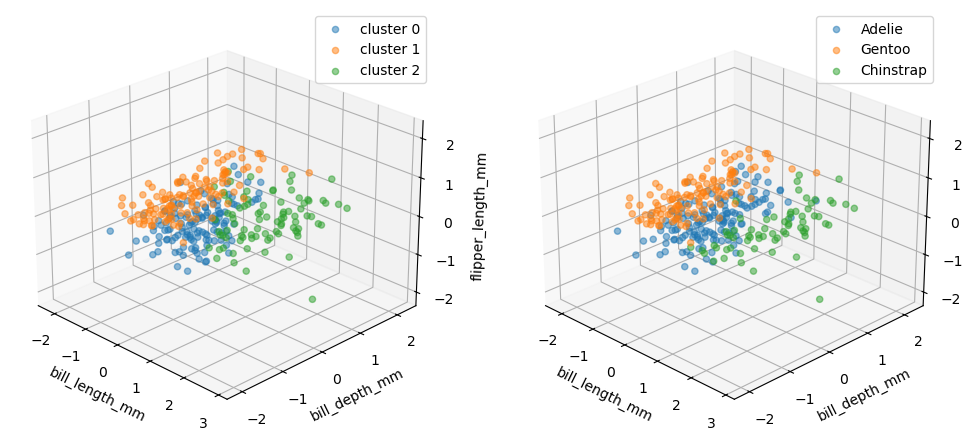

In [35]:
# pull out some data
X = df[["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]].values
Y = df["species"].values

X = StandardScaler().fit_transform(X)  # comment to switch of scaling if wanted

# instantiate model and fit with all data (no target data is needed since unsupervised)
model = KMeans(n_clusters=3, random_state=4)
Y_pred = model.fit_predict(X)

# do a 3d plot to have a look to see what is going on
key1, key2, key3 = "bill_length_mm", "bill_depth_mm", "flipper_length_mm"

fig = plt.figure(figsize=(12, 6))

# predicted clusters
ax = plt.subplot(1, 2, 1, projection="3d")
for i in range(3):
    ax.scatter(X[Y_pred==i, 0],
               X[Y_pred==i, 1],
               X[Y_pred==i, 2],
               label=f"cluster {i}",
               alpha=0.5)
ax.set_xlabel(f"{key1}")
ax.set_ylabel(f"{key2}")
ax.set_zlabel(f"{key3}")
ax.grid(lw=0.5, zorder=0)
ax.legend()
ax.view_init(25, -45)

# ground truth
ax = plt.subplot(1, 2, 2, projection="3d")
for species in df["species"].unique():   # pick out all unique entries under `species`
    ax.scatter(X[df["species"] == species, 0],
               X[df["species"] == species, 1],
               X[df["species"] == species, 2],
               label=species,
               alpha=0.5,  # fade this for demonstration later
               )
ax.set_xlabel(f"{key1}")
ax.set_ylabel(f"{key2}")
ax.set_zlabel(f"{key3}")
ax.grid(lw=0.5, zorder=0)
ax.legend()
ax.view_init(25, -45);

By eye there is clearly some mismatch going on if you do this brute force. To be more quantitative about it, if we think in this case the colours are maching exactly (because I chose my `random_state` deliberately for this), then we can simply take `(Adelie, Gentoo, Chinstrap)` to `(0, 1, 2)`, and see how good the labels match up.

In [36]:
# straight forward comparison of labels doesn't work, manually doing a remapping
Y_remap = np.zeros(Y.shape)
Y_remap[Y == "Adelie"] = 0
Y_remap[Y == "Gentoo"] = 1
Y_remap[Y == "Chinstrap"] = 2

N = len(Y_pred)
N_0, N_1, N_2 =len(Y_remap[Y_remap==0]), len(Y_remap[Y_remap==1]), len(Y_remap[Y_remap==2])
skill_all = np.sum(Y_pred == Y_remap)
skill_0   = np.sum(Y_pred[Y_remap==0] == Y_remap[Y_remap==0])
skill_1   = np.sum(Y_pred[Y_remap==1] == Y_remap[Y_remap==1])
skill_2   = np.sum(Y_pred[Y_remap==2] == Y_remap[Y_remap==2])
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
print(f"    cluster 0: {skill_0} correct out of {N_0} ({skill_0/N_0*100:.2f}%)")
print(f"    cluster 1: {skill_1} correct out of {N_1} ({skill_1/N_1*100:.2f}%)")
print(f"    cluster 2: {skill_2} correct out of {N_2} ({skill_2/N_2*100:.2f}%)")
print(" ")

overall skill: 313 correct out of 342 (91.52%)
    cluster 0: 127 correct out of 151 (84.11%)
    cluster 1: 123 correct out of 123 (100.00%)
    cluster 2: 63 correct out of 68 (92.65%)
 


It's actually pretty good (it wasn't when I didn't standardise the data). 

The below does the same but includes a $t$-SNE step; for the same choice of `random_state` I need to do a slightly different label remapping here.

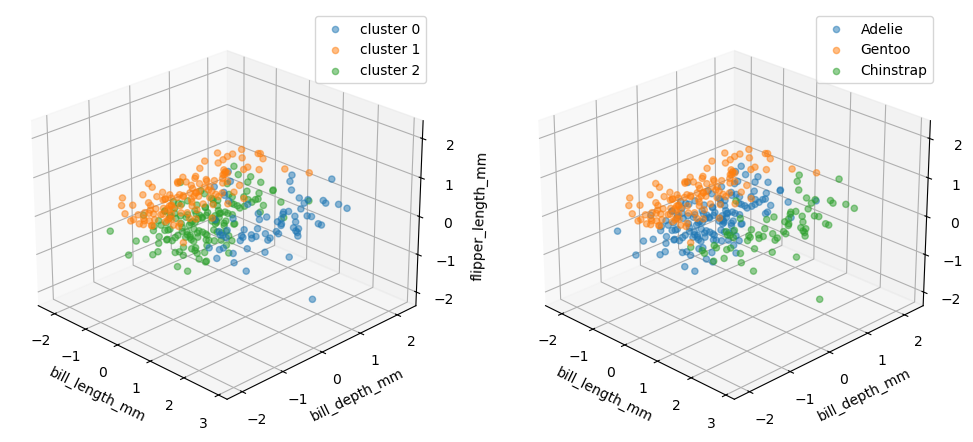

In [37]:
# as above but with a TSNE step

X = df[["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]].values
Y = df["species"].values

tsne = TSNE(random_state=4)  # default of 2 components (so 2 dimensions)
X = StandardScaler().fit_transform(X)  # comment to switch of scaling if wanted
X_tsne = tsne.fit_transform(X)

# instantiate model and fit with all data (no target data is needed since unsupervised)
model = KMeans(n_clusters=3, random_state=4)
Y_pred = model.fit_predict(X_tsne)

# do a 3d plot to have a look to see what is going on
key1, key2, key3 = "bill_length_mm", "bill_depth_mm", "flipper_length_mm"

fig = plt.figure(figsize=(12, 6))

# predicted clusters
ax = plt.subplot(1, 2, 1, projection="3d")
for i in range(3):
    ax.scatter(X[Y_pred==i, 0],
               X[Y_pred==i, 1],
               X[Y_pred==i, 2],
               label=f"cluster {i}",
               alpha=0.5)
ax.set_xlabel(f"{key1}")
ax.set_ylabel(f"{key2}")
ax.set_zlabel(f"{key3}")
ax.grid(lw=0.5, zorder=0)
ax.legend()
ax.view_init(25, -45)

# ground truth
ax = plt.subplot(1, 2, 2, projection="3d")
for species in df["species"].unique():   # pick out all unique entries under `species`
    ax.scatter(X[df["species"] == species, 0],
               X[df["species"] == species, 1],
               X[df["species"] == species, 2],
               label=species,
               alpha=0.5,  # fade this for demonstration later
               )
ax.set_xlabel(f"{key1}")
ax.set_ylabel(f"{key2}")
ax.set_zlabel(f"{key3}")
ax.grid(lw=0.5, zorder=0)
ax.legend()
ax.view_init(25, -45);

In [38]:
# straight forward comparison of labels doesn't work, manually doing a remapping
Y_remap = np.zeros(Y.shape)
Y_remap[Y == "Adelie"] = 2
Y_remap[Y == "Gentoo"] = 1
Y_remap[Y == "Chinstrap"] = 0

N = len(Y_pred)
N_0, N_1, N_2 =len(Y_remap[Y_remap==0]), len(Y_remap[Y_remap==1]), len(Y_remap[Y_remap==2])
skill_all = np.sum(Y_pred == Y_remap)
skill_0   = np.sum(Y_pred[Y_remap==0] == Y_remap[Y_remap==0])
skill_1   = np.sum(Y_pred[Y_remap==1] == Y_remap[Y_remap==1])
skill_2   = np.sum(Y_pred[Y_remap==2] == Y_remap[Y_remap==2])
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
print(f"    cluster 0: {skill_0} correct out of {N_0} ({skill_0/N_0*100:.2f}%)")
print(f"    cluster 1: {skill_1} correct out of {N_1} ({skill_1/N_1*100:.2f}%)")
print(f"    cluster 2: {skill_2} correct out of {N_2} ({skill_2/N_2*100:.2f}%)")
print(" ")

overall skill: 329 correct out of 342 (96.20%)
    cluster 0: 63 correct out of 68 (92.65%)
    cluster 1: 123 correct out of 123 (100.00%)
    cluster 2: 143 correct out of 151 (94.70%)
 


This provides a mild increase in the clustering skill, which is nice to see.

> <span style="color:red">Q.</span> Explore what happens if I don't standardise. Why and where do you think the problem is? (The former you should know, the latter you might need to think a litte bit.)
>
> <span style="color:red">Q.</span> I didn't do `train_test_split`, but consider what happens if I do that, and see how good the label predictions are.
>
> <span style="color:red">Q.</span> Do an ensemble of these and see how robust the scores are.
>
> <span style="color:red">Q.</span> Explore above but with different hyperparameters, and evaluate the sensitivity of scores to hyperparameters.

There are other `sklearn` metrics one could evaluate things on; look up what those mean if you like.

> <span style="color:red">Q.</span> What do the numbers below mean?

In [39]:
from sklearn import metrics

# X = df[["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]].values
# X_scaled = StandardScaler().fit_transform(X)  # comment to switch of scaling if wanted

# try X or X without standardisation, produce different results
# X_tsne will be best because it is being properly scaled
silhouette = metrics.silhouette_score(X_tsne, Y_pred)
db_index = metrics.davies_bouldin_score(X_tsne, Y_pred)
ch_index = metrics.calinski_harabasz_score(X_tsne, Y_pred)
ari = metrics.adjusted_rand_score(Y_remap, Y_pred)
ami = metrics.adjusted_mutual_info_score(Y_remap, Y_pred)

# Print the metric scores
print(f"Silhouette Score: {silhouette:.2f}")
print(f"Davies-Bouldin Index: {db_index:.2f}")
print(f"Calinski-Harabasz Index: {ch_index:.2f}")
print(f"Adjusted Rand Index (ARI): {ari:.2f}")
print(f"Adjusted Mutual Information (AMI): {ami:.2f}")

Silhouette Score: 0.65
Davies-Bouldin Index: 0.50
Calinski-Harabasz Index: 2102.13
Adjusted Rand Index (ARI): 0.90
Adjusted Mutual Information (AMI): 0.87


---
## d) Validation and robustness

Given the randomness in the data and train/test split, two things you may want to ask are:

1. How robust is the model? (Did you get a model with good skill because you got lucky?)
2. How generalisable is your model?

ML models are generally prone to ***over-fitting***, in that it is easy to keep adding complexity into the model, which usually improves the skill over the training data, but fail miserably in the testing data. Going to illustrate a few things one could do to mitigate this a bit.

If you go back to the first graph in the notebook where I coloured the data by `species`, you will notice that `Gentoo` is well-separated from `Adelie` and `Chinstrap`, so if I do a linear regression of those only those it will give me very different results. Below code demonstrates this.

In [40]:
# load the data
option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "penguins.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/penguins.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(path)

target_vars = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
ind = [3, 1]

loading data remotely


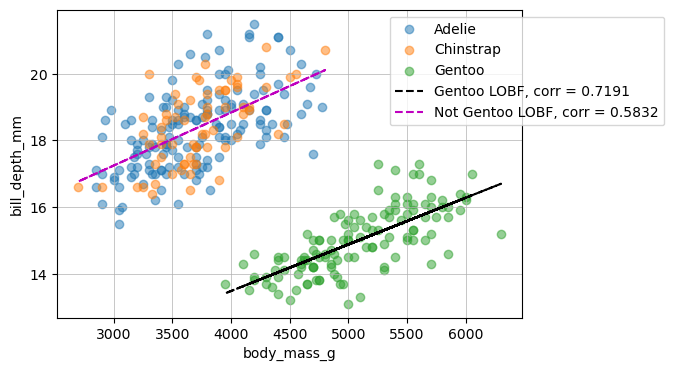

In [41]:
# show difference of regression of Gentoo and (Adelie, Chinstrap)

fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
for species in np.sort(df["species"].unique()):   # pick out all unique entries under `species`
    ax.scatter(df[df["species"] == species][target_vars[ind[0]]],
               df[df["species"] == species][target_vars[ind[1]]],
               label=species,
               alpha=0.5,  # fade this for demonstration later
               )

# fit gentoo data
X = df[df["species"] == "Gentoo"][target_vars[ind[0]]].values.reshape(-1, 1)
Y = df[df["species"] == "Gentoo"][target_vars[ind[1]]].values.reshape(-1, 1)
model = LinearRegression().fit(X, Y)
ax.plot(X, model.predict(X), 'k--', label=f"Gentoo LOBF, corr = {r_regression(X, Y.ravel())[0]:.4f}")

# fit other data (find NOT gentoos)
X = df[df["species"] != "Gentoo"][target_vars[ind[0]]].values.reshape(-1, 1)
Y = df[df["species"] != "Gentoo"][target_vars[ind[1]]].values.reshape(-1, 1)
model = LinearRegression().fit(X, Y)
ax.plot(X, model.predict(X), 'm--', label=f"Not Gentoo LOBF, corr = {r_regression(X, Y.ravel())[0]:.4f}")

ax.set_xlabel(f"{target_vars[ind[0]]}")
ax.set_ylabel(f"{target_vars[ind[1]]}")
ax.grid(lw=0.5, zorder=0)
le = ax.legend()
le.set_bbox_to_anchor([0.7, 0.8, 0.2, 0.2])

Notice the correlation of both models are positive (as it should be), and is of different sign to the correlation coefficient if all data is used. The example here is a bit contrived in that fitting to the whole data using a linear model is clearly not the best thing to do given the clear separation by species, but it demonstrates the point that, given the inherent randomness in data selection, there are likely variations in the model that results. If the model depends sensitively on the data then that's probably not a good thing to have.

Well just like we don't (at least we shouldn't) do one trial and conclude from it (unless there is strong reason to believe the system is strongly deterministic, e.g. some physical systems), one way to investigate ***robustness/uncertainties*** in model is to do a few of these and take averages if need be. I am going to go further in this case and run a ton of `train_test_split`s, spit out the relevant model parameters, and plot the resulting histogram to get a sense of the pdf.

> NOTE: I am effectively training an ***ensemble*** of models here. We will come back to ensembles in e.g. `07_forests` (***random forests*** and ***gradient boosting*** are ensemble methods that can be applied to ***decision trees***).

In [42]:
# do a ton of trials of LinearRegression (Y = aX + b) but changing the train_test_split
X = df[target_vars[ind[0]]].values.reshape(-1, 1)
Y = df[target_vars[ind[1]]].values.reshape(-1, 1)

# number of trials and initialise arrays to dump statistics in
n = 100
stats = np.zeros((n, 6))  # a, b, MSE on test data, MAE on test data, r, R2
model = LinearRegression()

for i in range(n):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    model.fit(X_train, Y_train)
    stats[i, 0], stats[i, 1] = model.coef_[0, 0], model.intercept_[0]

    Y_pred = model.predict(X_test)
    stats[i, 2] = mean_squared_error(Y_test, Y_pred)
    stats[i, 3] = mean_absolute_error(Y_test, Y_pred)

    stats[i, 4] = model.score(X_test, Y_test)
    stats[i, 5] = r_regression(X_train, Y_train.ravel())[0]

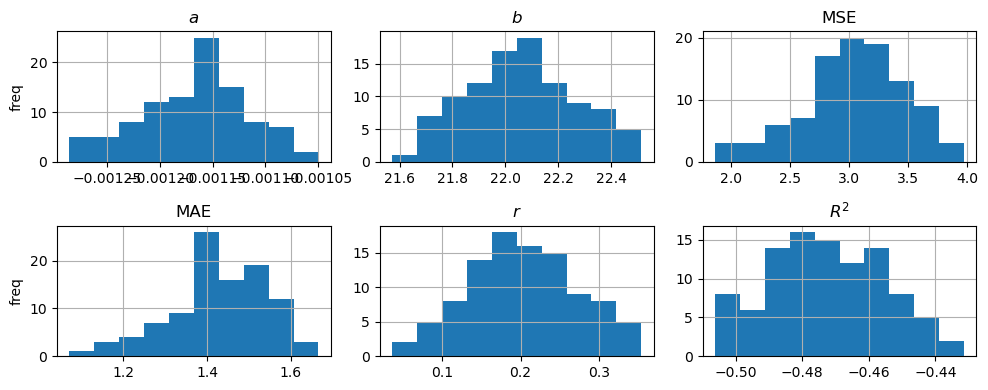

In [43]:
# plot out the above statistics
labels = [r"$a$", r"$b$", "MSE", "MAE", r"$r$", r"$R^2$"]

fig = plt.figure(figsize=(10, 4))
for j in range(6):
    ax = plt.subplot(2, 3, j+1)
    ax.hist(stats[:, j])
    ax.set_title(labels[j])
    ax.grid()
    if j % 3 == 0:
        ax.set_ylabel("freq")
plt.tight_layout()

You can compute the mean and standard deviations of these if you want to, but looking at the histogram the resulting model can be argued to be reasonably robust probably (this would actually be easier to see if the data was standardised). That's not surprising because linear regression is simple enough it probably can't do too many insane things. The same cannot be said of other models.

> <span style="color:red">Q.</span> Do the above but scale the data, and convince yourself the same conclusions above effectively holds.
>
> <span style="color:red">Q.</span> Compute the standard deviations and means (for raw or standardised data, or both if you really want to) and report the model values and statistics of those accordingly using appropriate `print` commands.
>
> <span style="color:red">Q.</span> Explore what happens to the statistics reported above when you change the `test_size` value in `train_test_split`. (Have a think what you would expect if `test_size` were to ***increase*** substantially.)

### Over-fitting

To demonstrate ***over-fitting*** and thus the need for cross-validation I am going to do **polynomial** regression instead but using `np.polyfit` (could also this through `sklearn.preprocessing.PolynomialFeatures`). In this case my (only) ***hyperparameter*** of the model would be the degree of fitting; linear regression is fitting to a polynomial of degree 1. The goal is to choose one that balances skill with some degree of robustness: in this case I want (relatively) lower MSE/MAE scores, and maybe that the spread of the model statistics is not completely wild.

I am going to fix the training/testing split to reduce the degree of possible variations.

In [44]:
# Not going reshape because I don't need it when using np.polyfit

X = df[target_vars[ind[0]]].values
Y = df[target_vars[ind[1]]].values

# fix the seed for reproducibility purposes
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

n = 10
MSE_train, MAE_train = np.zeros(n), np.zeros(n)
MSE_test, MAE_test = np.zeros(n), np.zeros(n)
for deg in range(n):
    model = np.polyfit(X_train, Y_train, deg+1)
    Y_pred = np.polyval(model, X_train)
    MSE_train[deg] = mean_squared_error(Y_pred, Y_train)
    MAE_train[deg] = mean_absolute_error(Y_pred, Y_train)
    Y_pred = np.polyval(model, X_test)
    MSE_test[deg] = mean_squared_error(Y_pred, Y_test)
    MAE_test[deg] = mean_absolute_error(Y_pred, Y_test)

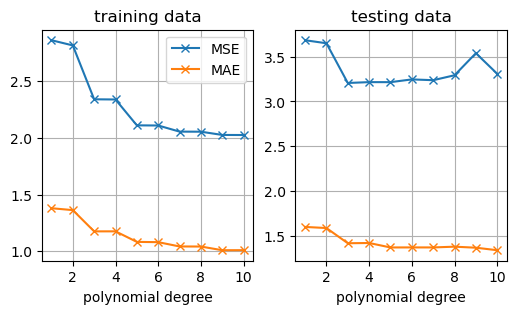

In [45]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 2, 1)
ax.plot(np.arange(1, n+1), MSE_train, "C0-x", label="MSE")
ax.plot(np.arange(1, n+1), MAE_train, "C1-x", label="MAE")
ax.set_xlabel("polynomial degree")
ax.set_title("training data")
ax.grid()
ax.legend()

ax = plt.subplot(1, 2, 2)
ax.plot(np.arange(1, n+1), MSE_test, "C0-x", label="MSE")
ax.plot(np.arange(1, n+1), MAE_test, "C1-x", label="MAE")
ax.set_xlabel("polynomial degree")
ax.set_title("testing data")
ax.grid()

Above graph suggests that errors in the training are decreasing with increasing polynomial degree, although it is tapering off. This is not surprising as increased complexity generally allows for a better fit. On the other hand, the MSE error has reached some sort of minimum by degree 3, and increasing the degree doesn't do much for the skill of interest. Both of these are symptoms of over-fitting, where the model skill increases with complexity but then fails to generalise as well to unseen data.

> <span style="color:red">Q.</span> In the above case I am not really extrapolating as such because of how the data is distributed, but if I were extrapolating by feeding it an $X$ beyond the possible range of values I provide for the training then it would probably start returning insane values. Show that this is in fact the case (you don't need to go that far beyond the total range if your polynomial degree is high).
>
> <span style="color:red">Q.</span> Evaluate the robustness of the above conclusion to the choice of random seed. The result should suggest to you that you may or may not want to therefore compute averages somehow to get some sense of the "optimal".

### Cross-validation

How do we go about selecting a model that has skill and is not too over-fitted? There isn't really one correct answer, but a main point is you probably need to multiple trains to evaluate dependence on the hyper-parameters etc., or take an average model of some sort.

Training on all the data can be costly and one way to explore the dependence on hyper-parameters is ***$k$-fold*** cross-validation:

* Split data into train and test sets as usual.
* Further split training data set into $k$ groups, and train a model on all $k$ of those.
* From that, make a decision what it means to be a "best" model (e.g. take the best model from the batch of $k$ models, take some average of the resulting parameters that describe the model, others...)
* Test the "best" model on the testing data set to evaluate over-fitting etc.

Doing this does not avoid over-fitting as such, but it does test for ***sensitivity***, which is an important thing to do given the inherent randomness in the procedures. Below code chooses the "best" model by:

1. The one with the lowest `MSE_test` score (where "test" means the ones from the $k$-fold split).
2. The avergage of all the trained models.

The we evaluate the skill on the withheld test data set.

In [46]:
# load the procedure to split the training data further
from sklearn.model_selection import KFold

X = df[target_vars[ind[0]]].values
Y = df[target_vars[ind[1]]].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# initialise a list and dump things in these
k = 5
deg = 5
model = np.zeros((deg+1, k))
MSE_train, MAE_train = np.zeros(k), np.zeros(k)  # don't actually use these but record anyway
MSE_test, MAE_test = np.zeros(k), np.zeros(k)

kf = KFold(n_splits=k)
i = 0

# only do k-fold split on the TRAINING data (the model still never sees the TESTING data)
for train, test in kf.split(X_train):  # these generate a bunch of indices
    model[:, i] = np.polyfit(X_train[train], Y_train[train], deg)
    MSE_train[i] = mean_squared_error(np.polyval(model[:, i], X_train[train]), Y_train[train])
    MAE_train[i] = mean_absolute_error(np.polyval(model[:, i], X_train[train]), Y_train[train])
    MSE_test[i] = mean_squared_error(np.polyval(model[:, i], X_train[test]), Y_train[test])
    MAE_test[i] = mean_absolute_error(np.polyval(model[:, i], X_train[test]), Y_train[test])
    i += 1

In [47]:
# best model from lowest MSE_test, and from an average of those models
model_best1 = model[:, np.where(MSE_test == np.min(MSE_test))[0][0]]
model_best2 = np.mean(model, axis=-1)  # averaging over the "model" dimension

# here we are passing (X_test, Y_test) in
MSE_best1 = mean_squared_error(np.polyval(model_best1, X_test), Y_test)
MSE_best2 = mean_squared_error(np.polyval(model_best2, X_test), Y_test)
MAE_best1 = mean_absolute_error(np.polyval(model_best1, X_test), Y_test)
MAE_best2 = mean_absolute_error(np.polyval(model_best2, X_test), Y_test)

print(f"model_best1 has:")
print(f"  coeffs = {model_best1}")
print(f"  MSE    = {MSE_best1:.6f}")
print(f"  MAE    = {MAE_best1:.6f}")
print(" ")
print(f"model_best2 has:")
print(f"  coeffs = {model_best2}")
print(f"  MSE    = {MSE_best2:.6f}")
print(f"  MAE    = {MAE_best2:.6f}")
print(" ")

model_best1 has:
  coeffs = [-8.75533810e-16  1.96943127e-11 -1.73410469e-07  7.46075052e-04
 -1.56772434e+00  1.30516592e+03]
  MSE    = 3.199619
  MAE    = 1.370188
 
model_best2 has:
  coeffs = [-9.69386804e-16  2.17446592e-11 -1.90998270e-07  8.20046583e-04
 -1.72016374e+00  1.42825764e+03]
  MSE    = 3.218224
  MAE    = 1.368688
 


Several things to be read from the above is that:

* The best model has lower MSE, but the "averaged" model has marginally better performance in MAE, so which is better is somewhat arguable...
* The resulting models are largely the same and has a large value in the last entry, in this case the leading coefficient of $X^5$. (This is probably not a good thing regarding over-fitting...)

> <span style="color:red">Q.</span> Play around with the choice of `k` and `deg`. I would expect the leading coefficient to still be large, which would indicate severe sensitivity if we are doing extrapolation.

We could also use some other in-built tools there to help with cross-validation (although it is good practice to do it once or twice by hand). Have a look at `cross_val_score`, `ShuffleSplit` as well as `Pipeline`. These can then be piggybacked for doing model selection and hyperparameter tuning, manually or using other `sklearn` objects. For length reasons I'm going to leave this for you to do in your own time instead. These can then be piggybacked for doing model selection and hyperparameter tuning, manually or using other `sklearn` objects. For length reasons I'm going to leave this for you to do in your own time instead.

The thing to note is over-fitting is potentially more subtle in other models, so it is prudent to do ensembles and/or cross-validate; you should basically assume the ML models you create are probably over-fitted in general, and provide evidence to the degree of over-fitting as appropriate. Later notebooks will demonstrate cross validation and testing for robustness sporadically, but the comprehensive exploration will largely be left as exercises.

> NOTE: There is an easier function `model_selection.cross_val_score` that could be used, but that requires an sklearn estimator object and doesn't play too well here for linear regression (partly because `LinearRegression` is too simple). We will use that briefly when we come to `03_linear_models_dim_reduction`.
>
### <span style="color:red">Comments on over-fitting and robustness of model is expected of all the assignments that are to be handed in.</span>
1. A portion of the marks under "coding" and marks under "science" will be given for (cross-)validation and related evaluations for model skill and robustness/sensitivity to hyper-parameters, data splitting etc. You automatically lose quite a lot of marks if you don't do it (cf. referencing: no one likes doing it as such, but it needs to be done).
3. Saying you've done (cross-)validation but without providing numerical evidence will be treated as if no (cross-)validation was done. I need to see some evidence of this in code form.
4. An ensemble calculation of about 5 to 10 would be minimally expected depending on the complexity of your problem (given you are not expected to be creating models that are large and thus slow to run).

----------------
# More involved exercises with this notebook

## 1) Polynomial regression

Consider doing polynomial regression using `sklearn.preprocessing.PolynomialFeatures`; this might be easier with [`pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) also. I basically did it manually above.

(Essentially choosing a [basis for the features](https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions), and is related to what we would do with [SINDy](https://pysindy.readthedocs.io/en/latest/), which we may visit in the bonus material.)

## 2) Generalised Linear Models (GLMs)

Have a look at [GLMs](https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-models), and try applying this in some of the examples above (or make up / apply to your own synthetic/real examples).

(The reason we don't touch this is because this requires you knowing more things about other probability distribution funtcions.)

## 3) Bayesian regression

Have a look at [Bayesian regession](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression), and try applying this in some of the examples above (or make up / apply to your own synthetic/real examples).

(The reason we don't touch this is because this requires you knowing the Bayesian formalism of probability/statistics.)

## 4) Predicting cat faces, and on model interpretability

Going to the raw images of cats, consider training linear models of the above ilk on half the face and using it to predict the other half. Analyse the skill on training data, testing data, the need for standardising the data, analysis of the model coefficients, dependence on the propotion of face exposed to model, cross-validation and etc.

From a coding point of view it is potentially easier to use the left half of the face to predict the right half (idea below). You can try top and bottom also.

<img src="https://i.imgur.com/G7xJJvu.jpeg" width="500" alt='cursed prediction'>

One interest here is in the model coefficients: the loading values would provide a suggestion on which pixels may matter the most in the training of the model for the prediction problem, which aids in ***interpretability*** of the model. We will come back to do this when we get to `04_Neural_Networks`.

## 5) Classification tasks and eigenpets

There is the analogous dog data called `dog.csv`; try and do an eigenpets decomposition say that uses both cats and dog data.

Then have a think how you might do ***classification*** of an image based on the features generated from eigenpets, and try and do that if you want to. One way to do it is simply say $Y=1$ is cat and $Y=-1$ is dog or analogously (i.e. you label the data), then you train a linear model based on the image and/or the eigenpet features. The predicted values will not be exactly $1$ or $-1$, but then you only need the sign of it (e.g. if predicted value is positive then it is a cat, and vice-versa).

## 6) Argo data

#### (This one is related to the upcoming assignment.)

Consider training models on the Argo profile to predict one of the depth, temperature and salinity from the other two (as a start). Do the usual data scaling, evaluation for robustness, cross-validation etc.

An extra thing to do would be to evalute whether the predictions are physically plausible:

* It is entirely possible the prediction leads to a density that is in fact gravitationally unstable, when we don't think this is likely the case.
* (Harder) The resulting density prediction contradicts the buoyancy frequency $N^2$ that is also present in the data.

## 7) Hyperparameter tuning and model selection

#### (May help with all upcoming assignments.)

Instead of doing things manually, have a look at [here](https://scikit-learn.org/stable/modules/grid_search.html#) to see how you might do hyperparameter tuning of the model. Within the same manual there are suggestions on how you might model selection also.

## 8) Spectral analysis

If you have seen Fourier analysis before, consider doing dimension reduction / data compression via Fourier transform (e.g. `np.rfft` or similar); this is a fairly standard thing to do for acoustic data and signal processing for example (e.g. music identification software such as [Shazam](https://www.shazam.com/)), and maintains the feature orthogonality property.

If you are feeling adventurous, you could try more general transforms (e.g. spherical harmonics, Bessel functions, wavelets).

(There is then potentially something to be said about doing machine learning to predict things leveraging the data structure these spectral/wavelet spaces, which can be more stable and robust. See for example [this paper](https://www.nature.com/articles/s41467-021-21481-0) and maybe a video on YouTube by [Steve Brunton](https://www.youtube.com/watch?v=W8PybqAk6Ik).)

## 9) Time-series forecasting

Consider taking something like the `elnino34_sst.data` and train a linear model to do forecasting: given previous now and maybe some previous time data (these are your $X$s), predict the next time (these are your $Y$s). These are basically [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)-like models but with no noise terms.

How many previous times you put in is up to you, but note that if you use the whole time series your model will be complex and you have very few values to regress over. A shorter time series may allow you to do train/test split.

If you need to, I suppose you could "cheat" and generate multiple similar time series by taking the `elnino34_sst.data` and add noise to it, and call that a new time series; this is a bit like ***bootstrapping*** I would imagine.

(You could also do something a bit more controlled by generating your time-series with a model of your choice. A particularly simple one would be a predator-prey or [Lotka-Volterra model](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations); if you look into the OCES 3301 repository there should already be an implementation there. A harder one would be a [Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system).)

## 10) Other clustering algorithms

There are a whole load of them at the [clustering](https://scikit-learn.org/stable/modules/clustering.html) page of `sklearn`. Have a look at them and see what you make of them, particularly of Gaussian Mixture Models (GMM), which I reference in the lecture but don't actually use it.

(You can also explore the other [manifold learning](https://scikit-learn.org/stable/modules/manifold.html) methods.)

## 11) Primer for the assignment: using labels to improve models for `penguins`

Use the identified clusters to train different linear models, or add the cluster labels in as an extra feature to train linear models. This is something you should do for the assignment with Argo data.

## 12) Clustering and/or manifold learning of cats (possibly also data cleaning)

(May be useful for dealing with the penguins/turtle dataset and in classification tasks.)

Consider applying clustering and/or manifold learning to cat images: this is a bit like what is done for the [digits dataset](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html), but larger dimension. I would start with the smaller `cats.csv` dataset first to see if you can identify clusters of data.

If you are feeling brave and/or have some computational resources lying around, consider using the larger `cat_bw_enlarged.csv` dataset, and possibly use these approaches to detect ***outliers*** (there are definitely outliers or "not good" images in the dataset). This may be one way to use machine learning to help clean data, then feed the cleaner dataset back in for machine learning.